In [ ]:
# 라이브러리 import 및 TensorFlow 버전 확인

import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# 데이터 다운로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

14628807/14628807 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4893335/4893335 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# IN - 텍스트로 로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [ ]:
# IN - Y(정답 라벨) 데이터 만들기
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [ ]:
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-2842916861.py:13: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
/tmp/ipython-input-2842916861.py:14: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
/tmp/ipython-input-2842916861.py:15: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [ ]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)  # 단어 사전 학습
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

tf.Tensor(
[[  23  902    5    1 1097    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 586    1    1    1    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1   68  345   28   33    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  102    1    2    1    1  844    1    1  570    1    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(5, 25), dtype=int64)


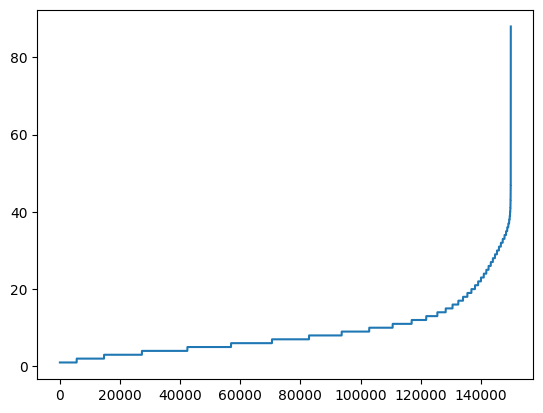

142587


In [ ]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [ ]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0

]

test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)

test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [ ]:
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,321 (1.01 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.6757 - loss: 0.5610 - val_accuracy: 0.7416 - val_loss: 0.4745
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.7486 - loss: 0.4662 - val_accuracy: 0.7510 - val_loss: 0.4622
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7554 - loss: 0.4546 - val_accuracy: 0.7582 - val_loss: 0.4576
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7537 - loss: 0.4530 - val_accuracy: 0.7620 - val_loss: 0.4536
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7555 - loss: 0.4482 - val_accuracy: 0.7436 - val_loss: 0.4779
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7592 - loss: 0.4454 - val_accuracy: 0.7627 - val_loss: 0.4551
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7638 - loss: 0.4386 - val_accuracy: 0.7580 - val_loss: 0.4567
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7660 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.4891, Test Accuracy: 0.7347


In [ ]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9890
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0610
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.1042
결과: 부정 😞


In [ ]:
history2 = model.fit(
    train_X, train_Y,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7904 - loss: 0.3887 - val_accuracy: 0.7528 - val_loss: 0.5091
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7937 - loss: 0.3861 - val_accuracy: 0.7517 - val_loss: 0.5242
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7962 - loss: 0.3830 - val_accuracy: 0.7512 - val_loss: 0.5228
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7974 - loss: 0.3795 - val_accuracy: 0.7543 - val_loss: 0.5280
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7994 - loss: 0.3760 - val_accuracy: 0.7542 - val_loss: 0.5342
Epoch 6/30
1923/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8013 - loss: 0.3727

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Epoch=10 모델 (history)
train_loss_10 = history.history['loss']
val_loss_10 = history.history['val_loss']
train_acc_10 = history.history['accuracy']
val_acc_10 = history.history['val_accuracy']

# Epoch=30 모델 (history2)
train_loss_30 = history2.history['loss']
val_loss_30 = history2.history['val_loss']
train_acc_30 = history2.history['accuracy']
val_acc_30 = history2.history['val_accuracy']

epochs_range_10 = range(1, len(train_loss_10) + 1)
epochs_range_30 = range(1, len(train_loss_30) + 1)

# 그래프 설정 (2x2 레이아웃)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Epoch=10 Loss 그래프
axes[0, 0].plot(epochs_range_10, train_loss_10, 'b-o', label='Training Loss', linewidth=2, markersize=4)
axes[0, 0].plot(epochs_range_10, val_loss_10, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
axes[0, 0].set_title('Loss (Epoch=10)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Epoch=10 Accuracy 그래프
axes[0, 1].plot(epochs_range_10, train_acc_10, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
axes[0, 1].plot(epochs_range_10, val_acc_10, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
axes[0, 1].set_title('Accuracy (Epoch=10)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Epoch=30 Loss 그래프
axes[1, 0].plot(epochs_range_30, train_loss_30, 'b-o', label='Training Loss', linewidth=2, markersize=4)
axes[1, 0].plot(epochs_range_30, val_loss_30, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
axes[1, 0].set_title('Loss (Epoch=30)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epochs', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Epoch=30 Accuracy 그래프
axes[1, 1].plot(epochs_range_30, train_acc_30, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
axes[1, 1].plot(epochs_range_30, val_acc_30, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
axes[1, 1].set_title('Accuracy (Epoch=30)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'history2' is not defined

In [ ]:
from tensorflow.keras.layers import SimpleRNN
import random

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    ),
    SimpleRNN(units=50), #RNN 사용
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

rnn_model.summary()
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         8,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,279 (1.02 MB)

 Trainable params: 268,279 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_rnn = rnn_model.fit(
	train_X, train_Y,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_split=0.2,
	verbose=1
)

Epoch 1/10
1187/3750 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.5965 - loss: 0.6510

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = rnn_model.evaluate(test_X, test_Y, verbose=0)
print(f"Rnn Test Loss: {test_loss:.4f}, Rnn Test Accuracy: {test_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
example_sentences = [
    "배우연기는 좋았지만 스토리가 아쉬웠다",
    "스토리는 아쉬웠지만 배우 연기는 좋았다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

In [ ]:
from tensorflow.keras.layers import LSTM
import random

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    ),
    LSTM(units=50), #RNN 사용
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

lstm_model.summary()
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,129 (1.13 MB)

 Trainable params: 295,129 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(
	train_X, train_Y,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_split=0.2,
	verbose=1
)

In [ ]:
test_loss, test_acc = lstm_model.evaluate(test_X, test_Y, verbose=0)
print(f"LSTM Test Loss: {test_loss:.4f}, LSTM Test Accuracy: {test_acc:.4f}")

In [ ]:
example_sentences = [
    "이 영화는 정말 재미있고, 스토리도 흥미진진하며 배우들의 연기까지 완벽해서 끝까지 눈을 뗄 수 없었었요.",
    "영화가 전체적으로 너무 지루하고 전개가 느려서 몰입하기 힘들었으며, 기대했던 재미나 감동이 전혀 없었어요."
]

example_seq = vectorize_layer(example_sentences)
pred_rnn = rnn_model.predict(example_seq)
pred_lstm = lstm_model.predict(example_seq)

for s, p1, p2 in zip(example_sentences, pred_rnn, pred_lstm):
    print(f"문장: {s}")
    print(f"RNN 긍정 확률: {p1[0]:.4f}")
    print(f"LSTM 긍정 확률: {p2[0]:.4f}")
    print("결과:", "긍정 😊" if p1[0] > 0.5 else "부정 😞")
    print("결과:", "긍정 😊" if p2[0] > 0.5 else "부정 😞")

In [ ]:
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, LayerNormalization, Input,
    GlobalAveragePooling1D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MultiHeadAttention

In [ ]:
class TokenAndPositionalEmbedding(tf.keras.layers.Layer):
	# Token Embedding
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(vocab_size, embed_dim)
        self.pos_emb = Embedding(maxlen, embed_dim)
	# Positional Embedding
    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        return self.token_emb(x) + positions

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # MultiHeadAttention
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        # Feed Forward Network (FFN)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
    # Residual Connection + LayerNormalization
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layernorm2(out1 + ffn_output)

In [ ]:
MAX_LEN = 25
VOCAB_SIZE = 2000
EMBEDDING_DIM = 64
NUM_HEADS = 2
FF_DIM = 128
DROPOUT_RATE = 0.1
NUM_BLOCKS = 2
EPOCHS = 5
BATCH_SIZE = 32


inputs = Input(shape=(MAX_LEN,))
x = TokenAndPositionalEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)

for _ in range(NUM_BLOCKS):
    x = TransformerBlock(EMBEDDING_DIM, NUM_HEADS, FF_DIM, DROPOUT_RATE)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)

transformer_model = Model(inputs, outputs)

In [ ]:
inputs = Input(shape=(MAX_LEN,))
x = TokenAndPositionalEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)

for _ in range(NUM_BLOCKS):
    x = TransformerBlock(EMBEDDING_DIM, NUM_HEADS, FF_DIM, DROPOUT_RATE)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)

transformer_model = Model(inputs, outputs)

In [ ]:
transformer_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = transformer_model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 129s 33ms/step - accuracy: 0.6925 - loss: 0.5506 - val_accuracy: 0.7585 - val_loss: 0.4586
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 143s 33ms/step - accuracy: 0.7540 - loss: 0.4613 - val_accuracy: 0.7602 - val_loss: 0.4576
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 121s 32ms/step - accuracy: 0.7587 - loss: 0.4520 - val_accuracy: 0.7622 - val_loss: 0.4623
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 32ms/step - accuracy: 0.7628 - loss: 0.4436 - val_accuracy: 0.7606 - val_loss: 0.4720
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 123s 33ms/step - accuracy: 0.7648 - loss: 0.4369 - val_accuracy: 0.7585 - val_loss: 0.4815


In [ ]:
test_loss, test_acc = transformer_model.evaluate(test_X, test_Y, verbose=0)
print(test_loss, test_acc)

0.4973524212837219 0.7422599792480469


In [ ]:
example_sentences = [
    "이 영화는 정말 재미있고, 스토리도 흥미진진하며 배우들의 연기까지 완벽했다.",
    "전체적으로 지루하고 재미가 없었다.",
]

example_seq = vectorize_layer(example_sentences)
pred = transformer_model.predict(example_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
